In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, Embedding, MultiHeadAttention, Conv2D, Flatten
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
import re
import os

# Recuperer la data
dataset = load_dataset("emotion")

# Fonction de nettoyage du texte
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)   # Suppression des URLs
    text = re.sub(r'#\w+', '', text)           # Suppression des hashtags
    text = re.sub(r'@\w+', '', text)           # Suppression des mentions
    text = re.sub(r'\d+', '', text)            # Suppression des nombres
    text = re.sub(r'[^\w\s]', '', text)        # Suppression des caractères spéciaux
    return text.lower()

# Paramètres
nb_words = 10000
embed_dim = 512
num_heads = 4
ff_dim = 512
maxlen = 100
num_classes = 8

# Préparation des données d'entraînement et de test
train_texts = [clean_text(example['text']) for example in dataset['train']]
train_labels = [example['label'] for example in dataset['train']]
test_texts = [clean_text(example['text']) for example in dataset['test']]
test_labels = [example['label'] for example in dataset['test']]

# Tokenization et padding
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=nb_words, oov_token='<UNK>')
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

x_train = pad_sequences(train_sequences, maxlen=maxlen)
x_test = pad_sequences(test_sequences, maxlen=maxlen)

y_train = tf.keras.utils.to_categorical(train_labels, num_classes)
y_test = tf.keras.utils.to_categorical(test_labels, num_classes)

c:\Users\eugen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\eugen\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [32]:
import pickle

# Sauvegarde du tokenizer dans un fichier
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# Définition du modèle Transformer
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [4]:
# Définition du modèle Transformer
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_classes, rate=0.1):
        super(Transformer, self).__init__()
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.trans_block = TransformerBlock(embed_dim, num_heads, ff_dim, rate)
        self.final_layer = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = x + positions
        x = self.trans_block(x, training=training)
        x = x[:, -1, :]
        return self.final_layer(x)

In [5]:
# Entraînement du modèle
model = Transformer(nb_words, embed_dim, num_heads, ff_dim, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.fit(x_train, y_train, batch_size=8, epochs=1, validation_data=(x_test, y_test))

2000/2000 [==============================] - 380s 189ms/step - loss: 1.0233 - accuracy: 0.6224 - val_loss: 0.3587 - val_accuracy: 0.8740


In [30]:
# Sauvegarde du modèle
model.save('model', save_format='tf')

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000001F981304540>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000001F981304540>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000001F981304540>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 1/5
400/400 [==============================] - 222s 552ms/step - loss: 0.2286 - accuracy: 0.9059 - val_loss: 0.2025 - val_accuracy: 0.9184
Epoch 2/5
400/400 [==============================] - 227s 568ms/step - loss: 0.1626 - accuracy: 0.9291 - val_loss: 0.2159 - val_accuracy: 0.9172
Epoch 3/5
400/400 [==============================] - 228s 571ms/step - loss: 0.1380 - accuracy: 0.9377 - val_loss: 0.2311 - val_accuracy: 0.9141
Epoch 4/5
400/400 [==============================] - 223s 558ms/step - loss: 0.1225 - accuracy: 0.9502 - val_loss: 0.2625 - val_accuracy: 0.9166
Epoch 5/5
400/400 [==============================] - 227s 568ms/step - loss: 0.1097 - accuracy: 0.9572 - val_loss: 0.2740 - val_accuracy: 0.9094
63/63 - 11s - loss: 0.3294 - accuracy: 0.8900 - 11s/epoch - 172ms/step

Test accuracy: 0.8899999856948853


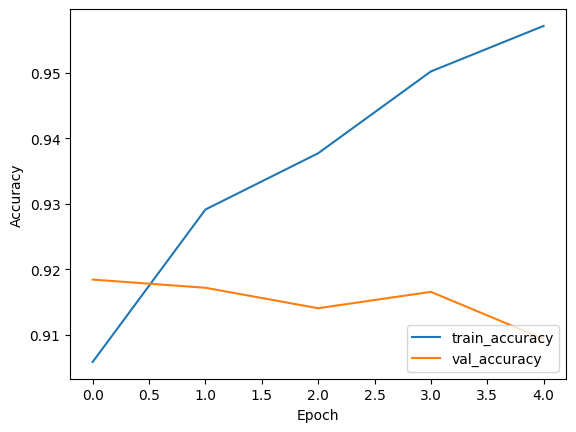

In [8]:
# Entraînement avec validation croisée
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

# Évaluation sur l'ensemble de test
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)

# Affichage des courbes d'apprentissage
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [9]:
# Importations pour la génération d'images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemin vers le dossier contenant les images
image_folder = "images"

# Création des générateurs d'images pour l'entraînement, la validation et le test
image_height = 224
image_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(image_folder, 'train'),
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    directory=os.path.join(image_folder, 'validation'),
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(image_folder, 'test'),
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 90043 images belonging to 8 classes.
Found 19292 images belonging to 8 classes.
Found 19302 images belonging to 8 classes.


In [10]:
!pip install matplotlib

1/1 [==============================] - 0s 33ms/step


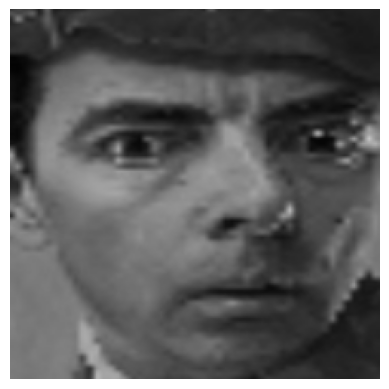

Prédiction d'émotion: fear


In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# Fonction pour nettoyer le texte
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)   # Suppression des URLs
    text = re.sub(r'#\w+', '', text)           # Suppression des hashtags
    text = re.sub(r'@\w+', '', text)           # Suppression des mentions
    text = re.sub(r'\d+', '', text)            # Suppression des nombres
    text = re.sub(r'[^\w\s]', '', text)        # Suppression des caractères spéciaux
    return text.lower()

# Fonction pour prédire l'émotion à partir d'une phrase
def predict_emotion_from_text(model, tokenizer, sentence, maxlen):
    sentence = clean_text(sentence)
    sequence = tokenizer.texts_to_sequences([sentence])
    sequence_padded = pad_sequences(sequence, maxlen=maxlen)
    prediction = model.predict(sequence_padded)
    return prediction

# Chemins vers les répertoires de chaque émotion
emotion_folders = {
    "sadness": "images/test/sad",
    "joy": "images/test/happy",
    "love": "images/test/love",
    "anger": "images/test/anger",
    "fear": "images/test/fear",
    "surprise": "images/test/surprise",
    "neutral": "images/test/neutral",
    "contempt": "images/test/contempt",
    "disgust": "images/test/disgust"
}

# Fonction pour choisir une image au hasard dans un répertoire
def choose_random_image_from_folder(folder_path):
    images = os.listdir(folder_path)
    random_image = random.choice(images)
    return os.path.join(folder_path, random_image)

# Fonction pour afficher une image correspondant à une émotion
def display_image_for_emotion(emotion):
    # Chemin vers le répertoire contenant les images de cette émotion
    emotion_folder_path = emotion_folders.get(emotion)
    
    if emotion_folder_path:
        # Choix d'une image au hasard dans le dossier de cette émotion
        image_path = choose_random_image_from_folder(emotion_folder_path)
        
        # Affichage de l'image
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
       # Affichage de la prédiction
        print("Prédiction d'émotion:", emotion)
    else:
        print("Le chemin vers le répertoire de cette émotion n'est pas spécifié.")


# Phrase à tester
phrase = "i'm afraid about this monster"

# Prédiction de l'émotion à partir de la phrase
prediction = predict_emotion_from_text(model, tokenizer, phrase, maxlen)

# Affichage de l'image correspondant à l'émotion prédite
emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise", "neutral", "contempt", "disgust"]
predicted_emotion = emotion_labels[prediction.argmax()]
display_image_for_emotion(predicted_emotion)